Random seed set to 42
All results will be saved to the 'results' directory.
Start training parameter network...
Epoch     0 | Total Loss: 749.205322 | Data Loss: 436.394531 | Constraint Loss: 27.592678
Epoch   100 | Total Loss: 3.702207 | Data Loss: 1.760170 | Constraint Loss: 0.106730
Epoch   200 | Total Loss: 2.422757 | Data Loss: 1.620832 | Constraint Loss: 0.239717
Epoch   300 | Total Loss: 2.890196 | Data Loss: 1.583259 | Constraint Loss: 0.264433
Epoch   400 | Total Loss: 4.128956 | Data Loss: 1.495781 | Constraint Loss: 0.251970
Epoch   500 | Total Loss: 4.277897 | Data Loss: 1.415265 | Constraint Loss: 0.162987
Epoch   600 | Total Loss: 1.954138 | Data Loss: 1.390026 | Constraint Loss: 0.190377
Epoch   700 | Total Loss: 2.224861 | Data Loss: 1.419879 | Constraint Loss: 0.231984
Epoch   800 | Total Loss: 2.514049 | Data Loss: 1.363151 | Constraint Loss: 0.037880
Epoch   900 | Total Loss: 2.959427 | Data Loss: 1.411978 | Constraint Loss: 0.172909
Epoch  1000 | Total Loss: 1.96264

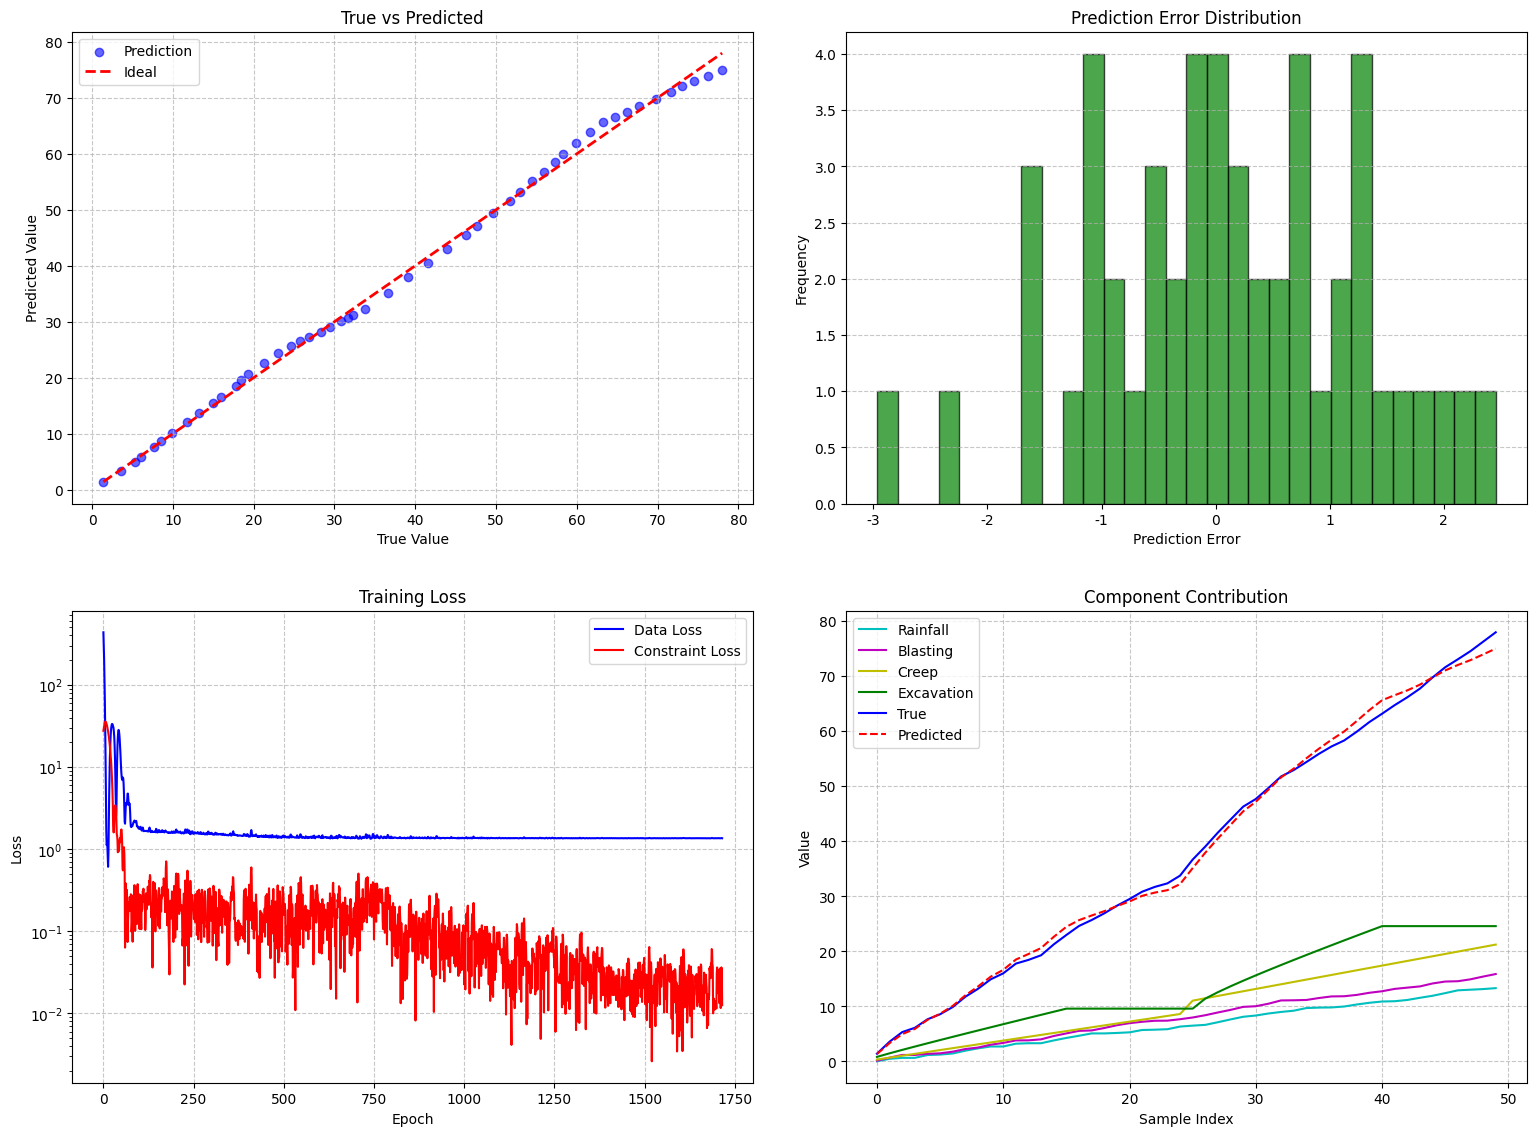

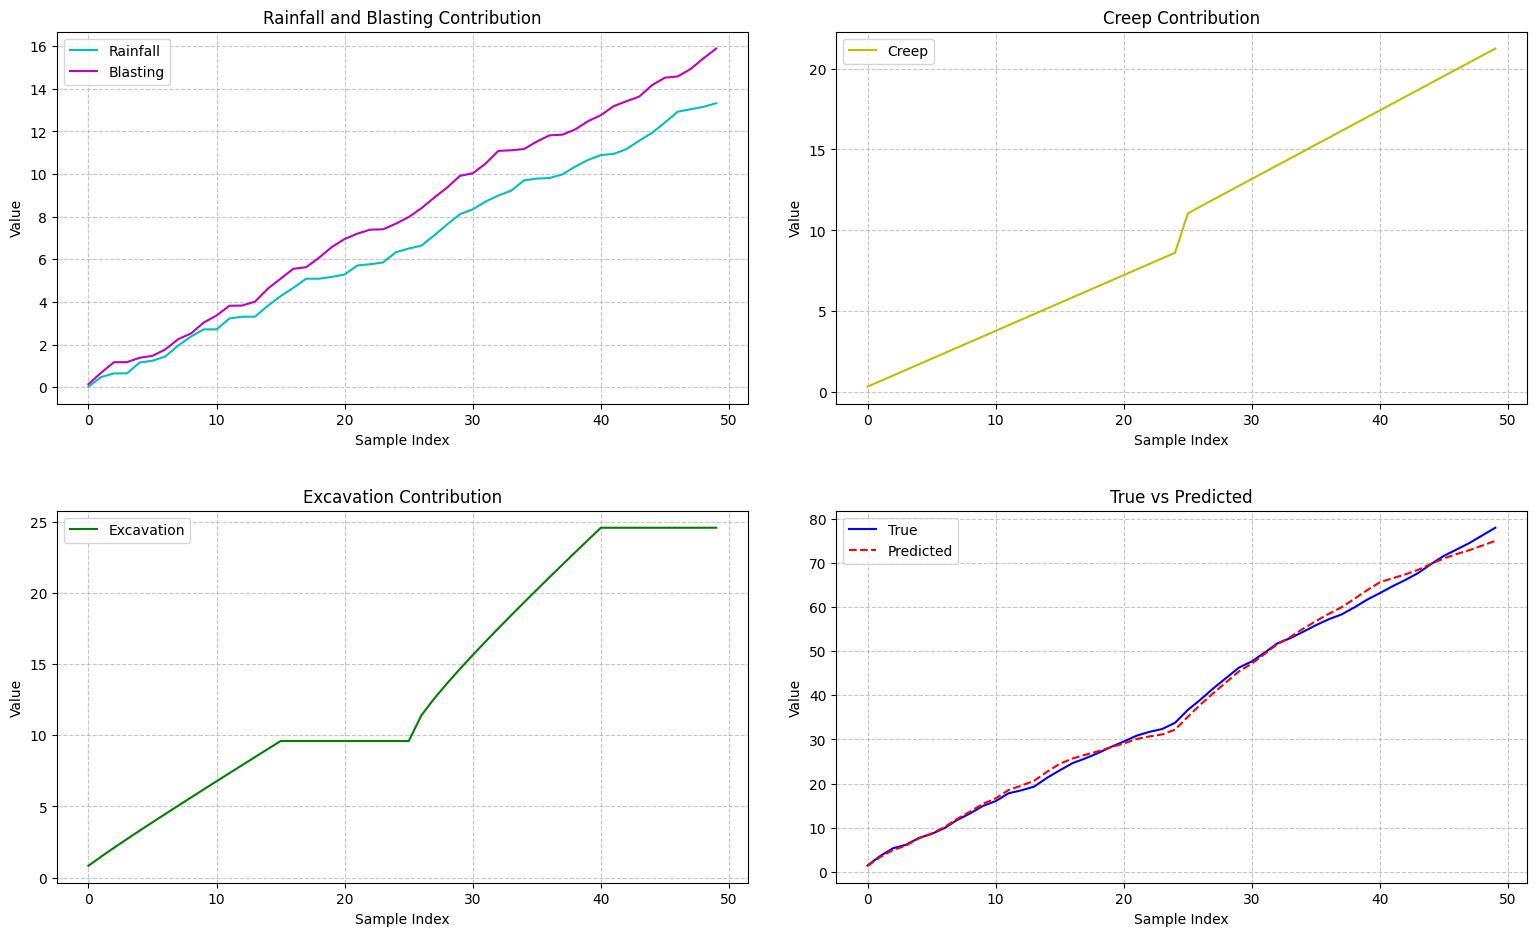

Results saved to results\results.xlsx

Final Parameters:
a1: 0.509014
b1: 0.597514
c1: 0.343055
c2: 0.479580
c3: 0.003414
c4: 0.423948
c5: 2.018707
c6: 5.027884
d1: 0.303183
d2: 0.523911
d3: 1.107500
d4: 0.713635


In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
import os
import time
from torch.optim import lr_scheduler

# Set all random seeds to ensure reproducibility
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Random seed set to {seed}")

# Set random seed
set_seed(42)

# Allow matplotlib to display negative signs
plt.rcParams['axes.unicode_minus'] = False

# ====================== Setup Output Directory ======================
output_dir = 'example_results'
os.makedirs(output_dir, exist_ok=True)
print(f"All results will be saved to the '{output_dir}' directory.")


# ====================== 1. Load Data ======================
data_file_path = os.path.join('example_data', 'example_data.xlsx')
df = pd.read_excel(data_file_path)
X = torch.tensor(df.iloc[:, 1:].values, dtype=torch.float32)
y_true = torch.tensor(df.iloc[:, 0].values.reshape(-1, 1), dtype=torch.float32)
n_samples = len(y_true)

CONSTRAINT_THRESHOLD = 0.5

# ====================== 2. Define Parameter Network ======================
class ParameterNet(nn.Module):
    def __init__(self, seed=42):
        super(ParameterNet, self).__init__()
        self.seed = seed
        self.softplus = nn.Softplus()

        # Positive parameters
        self.positive_params = nn.ParameterDict({
            name: nn.Parameter(torch.rand(1)) for name in [
                'a1', 'b1', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6'
            ]
        })

        # Parameters that can be negative
        self.free_params = nn.ParameterDict({
            name: nn.Parameter(torch.randn(1) * 0.1) for name in ['d1', 'd2', 'd3', 'd4']
        })

    def forward(self):
        activated_positive_params = {name: self.softplus(p[0]) for name, p in self.positive_params.items()}
        raw_free_params = {name: p[0] for name, p in self.free_params.items()}
        return {**activated_positive_params, **raw_free_params}

# ====================== 3. Prediction and Constraints ======================
def model_prediction(params, X):
    x1, x2, x3, x4, x5, x6 = X[:, 0], X[:, 1], X[:, 2], X[:, 3], X[:, 4], X[:, 5]
    y_pred = (
        params['a1'] * x1 +
        params['b1'] * x2 +
        params['c1'] * x3 +
        params['c2'] * (1 - torch.exp(-params['c3'] * x3)) +
        params['c4'] * x4 +
        params['c5'] * (1 - torch.exp(-params['c6'] * x4)) +
        params['d1'] * torch.sqrt(x5) +
        params['d2'] * x5 +
        params['d3'] * torch.sqrt(x6) +
        params['d4'] * x6
    )
    return y_pred.reshape(-1, 1)

def constraint_loss(params):
    constraint1 = torch.abs(params['d1'] * 4.0 + params['d2'] * 16.0 - 9.6)
    constraint2 = torch.abs(params['d3'] * torch.sqrt(torch.tensor(15.0)) + params['d4'] * 15.0 - 15.2)
    return constraint1 + constraint2

def is_constraint_satisfied(params):
    return constraint_loss(params) < CONSTRAINT_THRESHOLD

# ====================== 4. Loss Function ======================
def total_loss(params, X, y_true):
    y_pred = model_prediction(params, X)
    data_loss = torch.mean((y_pred - y_true)**2)
    cons_loss = constraint_loss(params)
    return data_loss + 10.0 * cons_loss

# ====================== 5. Train Network ======================
def train_parameter_net(net, X, y_true, epochs=5000, lr=0.05):
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=200, factor=0.5, min_lr=1e-6)

    loss_history, cons_loss_history, data_loss_history = [], [], []
    best_total_loss = float('inf')
    best_data_loss = float('inf')
    best_data_params = None
    best_epoch = 0
    patience = 1000
    no_improve_count = 0

    print("Start training parameter network...")
    start_time = time.time()
    for epoch in range(epochs):
        optimizer.zero_grad()
        params = net()
        loss = total_loss(params, X, y_true)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1.0)
        optimizer.step()

        with torch.no_grad():
            cons_loss = constraint_loss(params).item()
            y_pred = model_prediction(params, X)
            data_loss_val = torch.mean((y_pred - y_true)**2).item()
            total_loss_val = loss.item()
            scheduler.step(total_loss_val)

        loss_history.append(total_loss_val)
        cons_loss_history.append(cons_loss)
        data_loss_history.append(data_loss_val)

        if data_loss_val < best_data_loss and is_constraint_satisfied(params):
            best_data_loss = data_loss_val
            best_data_params = {name: param.item() for name, param in params.items()}
            best_epoch = epoch
            no_improve_count = 0
        else:
            no_improve_count += 1

        if epoch % 100 == 0:
            print(f"Epoch {epoch:5d} | Total Loss: {total_loss_val:.6f} | Data Loss: {data_loss_val:.6f} | Constraint Loss: {cons_loss:.6f}")

        if no_improve_count >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

    end_time = time.time()
    print(f"Training complete in {end_time - start_time:.2f} seconds.")
    print(f"Best Data Loss: {best_data_loss:.6f} at Epoch {best_epoch}")

    return best_data_params, loss_history, data_loss_history, cons_loss_history, best_data_loss

# ====================== 6. Execute Training ======================
param_net = ParameterNet(seed=42)
best_params, loss_history, data_loss_history, cons_loss_history, best_data_loss = train_parameter_net(
    param_net, X, y_true, epochs=5000, lr=0.05
)

params = {
    name: torch.nn.Parameter(torch.tensor(value, dtype=torch.float32, requires_grad=True))
    for name, value in best_params.items()
}
# ====================== 7. Final Prediction ======================
with torch.no_grad():
    y_pred = model_prediction(params, X).numpy().flatten()
    y_true_np = y_true.numpy().flatten()

# ====================== 8. Print Final Parameters and Constraints ======================
print("\nFinal fitted parameters:")
for name, param in params.items():
    print(f"{name}: {param.item():.6f}")

d1_val = params['d1'].item()
d2_val = params['d2'].item()
d3_val = params['d3'].item()
d4_val = params['d4'].item()
cons1 = d1_val * 4.0 + d2_val * 16.0
cons2 = d3_val * np.sqrt(15) + d4_val * 15.0
print(f"\nConstraint 1: d1*√16 + d2*16 = {cons1:.8f} (Target: 9.6), Diff: {abs(cons1 - 9.6):.8f}")
print(f"Constraint 2: d3*√15 + d4*15 = {cons2:.8f} (Target: 15.2), Diff: {abs(cons2 - 15.2):.8f}")
print(f"Final Data Loss: {data_loss_history[-1]:.6f}")
print(f"Best Data Loss: {best_data_loss:.6f}")

# ====================== 9. Component Contribution ======================
with torch.no_grad():
    x1_term = params['a1'] * X[:, 0]
    x2_term = params['b1'] * X[:, 1]
    x3_term = params['c1'] * X[:, 2] + params['c2'] * (1 - torch.exp(-params['c3'] * X[:, 2]))
    x4_term = params['c4'] * X[:, 3] + params['c5'] * (1 - torch.exp(-params['c6'] * X[:, 3]))
    x3x4_term = (x3_term + x4_term).numpy()
    x5_term = params['d1'] * torch.sqrt(X[:, 4]) + params['d2'] * X[:, 4]
    x6_term = params['d3'] * torch.sqrt(X[:, 5]) + params['d4'] * X[:, 5]
    x5x6_term = (x5_term + x6_term).numpy()
    total_pred = (x1_term + x2_term + x3_term + x4_term + x5_term + x6_term).numpy()

x1_term = x1_term.numpy()
x2_term = x2_term.numpy()

# ====================== 10. Visualization ======================
sample_index = np.arange(n_samples)

plt.figure(figsize=(16, 12))

plt.subplot(2, 2, 1)
plt.scatter(y_true_np, y_pred, alpha=0.6, color='blue', label='Prediction')
plt.plot([y_true_np.min(), y_true_np.max()], [y_true_np.min(), y_true_np.max()],
         'r--', linewidth=2, label='Ideal')
plt.xlabel('True Value')
plt.ylabel('Predicted Value')
plt.title('True vs Predicted')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.subplot(2, 2, 2)
errors = y_pred - y_true_np
plt.hist(errors, bins=30, color='green', alpha=0.7, edgecolor='black')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Prediction Error Distribution')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.subplot(2, 2, 3)
plt.plot(range(len(data_loss_history)), data_loss_history, color='blue', label='Data Loss')
plt.plot(range(len(cons_loss_history)), cons_loss_history, color='red', label='Constraint Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.yscale('log')

plt.subplot(2, 2, 4)
plt.plot(sample_index, x1_term, 'c-', label='Rainfall')
plt.plot(sample_index, x2_term, 'm-', label='Blasting')
plt.plot(sample_index, x3x4_term, 'y-', label='Creep')
plt.plot(sample_index, x5x6_term, 'g-', label='Excavation')
plt.plot(sample_index, y_true_np, 'b-', label='True')
plt.plot(sample_index, total_pred, 'r--', label='Predicted')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Component Contribution')
plt.legend(loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout(pad=3.0)
plt.savefig(os.path.join(output_dir, 'results_summary.png'), dpi=300)
plt.show()

# ====================== 11. Individual Component Visualization ======================
plt.figure(figsize=(16, 10))

plt.subplot(2, 2, 1)
plt.plot(sample_index, x1_term, 'c-', label='Rainfall')
plt.plot(sample_index, x2_term, 'm-', label='Blasting')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Rainfall and Blasting Contribution')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.subplot(2, 2, 2)
plt.plot(sample_index, x3x4_term, 'y-', label='Creep')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Creep Contribution')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.subplot(2, 2, 3)
plt.plot(sample_index, x5x6_term, 'g-', label='Excavation')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Excavation Contribution')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.subplot(2, 2, 4)
plt.plot(sample_index, y_true_np, 'b-', label='True')
plt.plot(sample_index, total_pred, 'r--', label='Predicted')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('True vs Predicted')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout(pad=3.0)
plt.savefig(os.path.join(output_dir, 'Decomposition.png'), dpi=300)
plt.show()

# ====================== 12. Save Results ======================
results_df = pd.DataFrame({
    'True': y_true_np,
    'Predicted': y_pred,
    'Error': errors,
    'x1': x1_term,
    'x2': x2_term,
    'x3+x4': x3x4_term,
    'x5+x6': x5x6_term
})

for name, param in params.items():
    results_df[f'param_{name}'] = param.item()

excel_path = os.path.join(output_dir, 'results.xlsx')
results_df.to_excel(excel_path, index=False)
print(f"Results saved to {excel_path}")


# ====================== 13. Print Final Parameters ======================
print("\nFinal Parameters:")
for name, param in params.items():
    print(f"{name}: {param.item():.6f}")